In [92]:
import os.path
from importlib import reload

import librosa as lib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from Signal_Analysis.features.signal import get_HNR
from vosk import Model
from scipy import signal, interpolate, ndimage

# tools work in progress
import tools
from tools import rec_vosk

reload(tools)


plt.style.use("dark_background")

mpl.rcParams["lines.linewidth"] = 0.5

plt.close("all")


model_path = "models/vosk-model-small-sv-rhasspy-0.15"

model = Model(model_path)


files = os.listdir("audio_preproc")

print(files)


file_path = os.path.join("audio_preproc", files[0])

['180923214834-Y20UOTIE-text-000_pp.wav', '181017140316-PM66PSO5-text-000_pp.wav', 'combo.wav', 'combo_pp.wav', 'female_canoe_pp.wav', 'female_canoe_pp[Resampled].MuWave', 'svenska_combo_pp.wav']


## Split by words

In [93]:
vowel_set = set("e y u i o å a ö ä".split())
print(vowel_set)

{'ä', 'o', 'e', 'y', 'i', 'a', 'u', 'ö', 'å'}


In [94]:
Fs, audio = wavfile.read(file_path)

words = rec_vosk(file_path, model)

segments, vowels_per_segment, s_start = tools.segment_by_words(
    words, audio, Fs, vowel_set, min_conf=1
)

0 i ------------------- from 0.3000 to 0.4200 sec, confidence: 100.00%
1 skymningen ---------- from 0.4200 to 1.2600 sec, confidence: 100.00%
2 en ------------------ from 1.3500 to 1.5000 sec, confidence: 100.00%
3 mycket -------------- from 1.5000 to 1.8000 sec, confidence: 100.00%
4 het ----------------- from 1.8300 to 2.1000 sec, confidence: 100.00%
5 dag ----------------- from 2.1000 to 2.4300 sec, confidence: 100.00%
6 i ------------------- from 2.4300 to 2.5200 sec, confidence: 100.00%
7 början -------------- from 2.5200 to 2.7900 sec, confidence: 100.00%
8 av ------------------ from 2.7900 to 2.9100 sec, confidence: 100.00%
9 juli ---------------- from 2.9100 to 3.3600 sec, confidence: 100.00%
10 lämnade ------------- from 3.3600 to 3.9900 sec, confidence: 100.00%
11 en ------------------ from 3.9900 to 4.1400 sec, confidence: 100.00%
12 ung ----------------- from 4.1400 to 4.4100 sec, confidence: 100.00%
13 man ----------------- from 4.4100 to 4.6800 sec, confidence: 100.00%
14

In [95]:
print(f"# words  :{len(segments)}")
print(vowels_per_segment)

# words  :108
[['i'], ['y', 'i', 'e'], ['e'], ['y', 'e'], ['e'], ['a'], ['i'], ['ö', 'a'], ['a'], ['u', 'i'], ['ä', 'a', 'e'], ['e'], ['u'], ['a'], ['i'], ['a', 'a', 'e'], ['o'], ['a'], ['ö', 'e'], ['i'], [], ['a'], ['e'], ['u'], ['å'], ['a', 'a'], ['o'], ['ö', 'a', 'e'], ['å', 'a'], ['o'], ['e'], ['a', 'a'], ['o', 'e', 'u', 'a'], ['å'], ['o'], ['o'], ['o'], ['e'], ['y', 'i', 'i'], ['a'], ['a'], ['ö', 'e'], ['ä', 'i', 'a'], ['i'], ['a', 'a'], ['a'], ['a', 'a', 'e'], ['o'], ['å'], ['a', 'e', 'e'], ['i'], ['u', 'e'], ['e'], ['ö', 'a'], ['e'], ['e', 'o'], ['i'], ['e', 'a'], ['i'], ['a'], ['i', 'a', 'e'], ['a'], ['a'], ['a'], ['ö', 'a'], ['e'], ['o', 'a'], ['ä', 'i', 'a'], ['o'], ['y', 'e'], ['u'], ['i'], ['u', 'a'], ['o'], ['ö'], ['o', 'o'], ['e'], ['i', 'a'], ['o'], ['a'], ['å'], ['o'], ['ä', 'i'], ['o', 'e'], ['ö'], ['i'], ['i'], ['e'], ['å', 'i'], ['e'], ['a', 'a'], ['e'], ['o'], ['ä'], ['a'], ['u', 'e'], ['u'], ['å', 'e'], ['e'], ['a', 'e', 'a'], ['ä', 'i', 'a'], ['e'], ['i', 'å'], ['

In [96]:
all_words_audio = tools.stitch_frames(segments, padding=Fs)

wavfile.write(os.path.join("output", "all_words.wav"), Fs, all_words_audio)

In [97]:
k = 10

x = segments[k].copy()
x = x / x.std()

wavfile.write(os.path.join("output", "one_word.wav"), Fs, tools.wavScaler(x))

In [98]:
print("vowels:", vowels_per_segment[k])

vowels: ['ä', 'a', 'e']


### Split by onset

In [99]:
splits_onset = lib.onset.onset_detect(y=x, sr=Fs, units="samples", backtrack=True)
print(splits_onset)

[ 2048  5120 13824 17920 22016]


In [100]:
starts = np.concatenate(([0], splits_onset))
ends = np.concatenate((splits_onset, [len(x)]))
print(starts)
frames_onset = []
for s, e in zip(starts, ends):
    frames_onset.append(x[s:e])

print(len(frames_onset))

wavfile.write(
    "output/frames_onsets.wav",
    Fs,
    tools.stitch_frames(frames_onset, padding=Fs / 2),
)

[    0  2048  5120 13824 17920 22016]
6


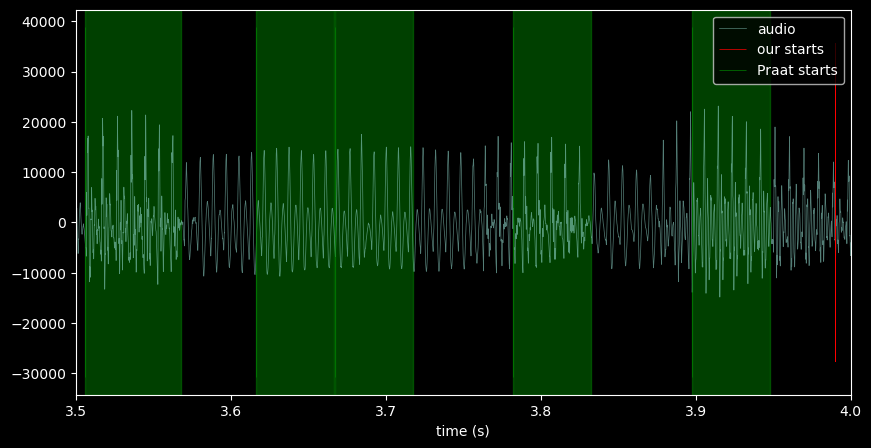

In [110]:
import pandas as pd

labels_path = (
    "example_speech_Andreas/180923214834-Y20UOTIE-text-000_vowels_timestamp_praat"
)

labels_df = pd.read_csv(labels_path)

starts_s = [(s + s_start[k]) / Fs for s in starts]
ends_s = [e / Fs + s_start[k] for e in ends]

plt.figure(figsize=(10, 5))
tt = np.arange(len(audio)) / Fs
plt.plot(tt, audio, alpha=0.6, label="audio")
plt.vlines(starts_s * Fs, *plt.ylim(), colors="r", label="our starts")
plt.vlines(labels_df.tmin, *plt.ylim(), colors="g", label="Praat starts")
for tmin, tmax in zip(labels_df.tmin, labels_df.tmax):
    plt.axvspan(tmin, tmax, alpha=0.5, color="g")


plt.xlabel("time (s)")

tr = (3.5, 4)

plt.xlim(*tr)
plt.legend()
plt.show()


In [102]:
hnr_frames_onset = [get_HNR(f, Fs) for f in frames_onset]

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: divide by zero encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\peakutils\peak.py:43: RuntimeWarning: invalid value encountered in scalar add
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


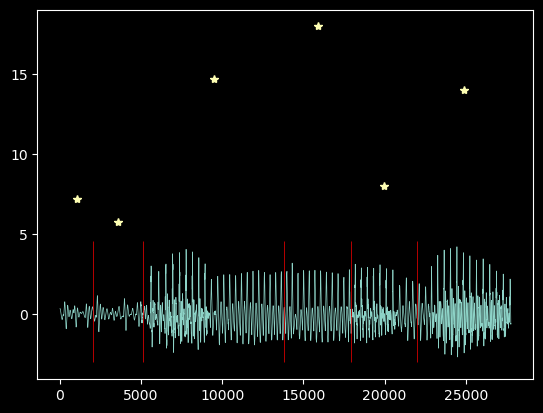

In [103]:
plt.figure()
plt.plot(x)
plt.vlines(splits_onset, *plt.ylim(), colors="r")
plt.plot((starts + ends) / 2, hnr_frames_onset, "*")
plt.show()

In [104]:
n_vowels = len(vowels_per_segment[k])
print(n_vowels, "vowels")

nth = sorted(hnr_frames_onset, reverse=True)[n_vowels]
frames_vowel = [
    frames_onset[i] for i in range(len(frames_onset)) if hnr_frames_onset[i] > nth
]

wavfile.write(
    f"output/vowels{n_vowels}.wav",
    Fs,
    tools.stitch_frames(frames_vowel, padding=Fs / 2),
)

3 vowels


In [105]:
word = words[k]["word"]
vowels = vowels_per_segment[k]
print(word)

vowels_cut = []
for i, v in enumerate(vowels):
    segment = frames_vowel[i]
    M = len(segment) / 2
    print(v + ":")
    # if v + "m" in word:
    #     print(v + "m")
    B = 1 / 3
    vowels_cut.append(segment[int(M - M * B) : int(M + M * B)])

wavfile.write(
    f"output/vowels_cut{n_vowels}.wav",
    Fs,
    tools.stitch_frames(vowels_cut, padding=Fs / 2),
)


lämnade
ä:
a:
e:


## Idea, clustering

(12, 55)


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=869
  warnings.warn(
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=435
  warnings.warn(
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=218
  warnings.warn(


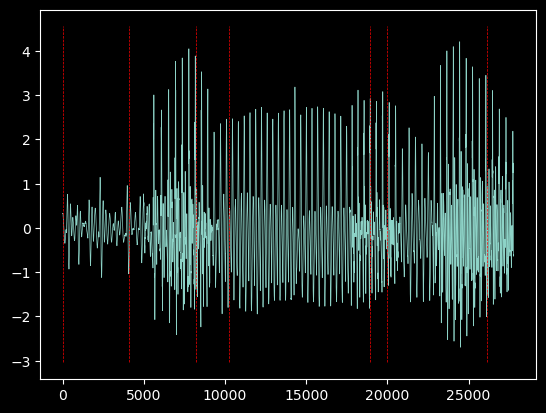

[    0  4096  8192 10240 18944 19968 26112]


In [106]:
chroma = lib.feature.chroma_cqt(y=x, sr=Fs)
s = lib.frames_to_samples(lib.segment.agglomerative(chroma, 7))

print(chroma.shape)


plt.figure()
plt.plot(x)
plt.vlines(s, *plt.ylim(), linestyles="dashed", color="r")
plt.show()

starts = s
ends = np.concatenate((s[1:], [len(x)]))
print(starts)
frames_chroma = []
for s, e in zip(starts, ends):
    frames_chroma.append(x[s:e])

wavfile.write(
    f"output/chroma{n_vowels}.wav",
    Fs,
    tools.stitch_frames(frames_chroma, padding=Fs / 2),
)

### idea, features(Hnr,power, etc)

## Idea, diff of power

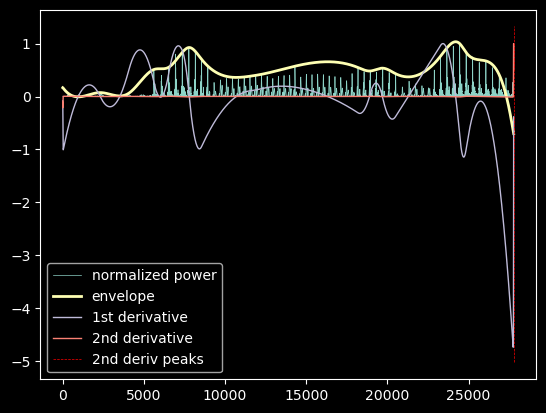

In [107]:
from tools import envelope

power = x**2
tt = np.arange(len(power))
power /= power.max()
env = envelope(power, 40)

env_d1 = np.gradient(env)
env_d1 /= env_d1.max()
env_d2 = np.gradient(env_d1)
env_d2 /= env_d2.max()

peaks_d2, peaks_d2_prop = signal.find_peaks(env_d2, height=0.01)

plt.figure()
plt.plot(power, label="normalized power")
plt.plot(tt, env, linewidth=2, label="envelope")
plt.plot(tt, env_d1, linewidth=1, label="1st derivative")
plt.plot(tt, env_d2, linewidth=1, label="2nd derivative")
plt.vlines(
    peaks_d2, *plt.ylim(), linestyles="dashed", colors="r", label="2nd deriv peaks"
)

plt.legend()
plt.show()

In [108]:
starts = np.concatenate(([0], peaks_d2))
ends = np.concatenate((peaks_d2, [len(x)]))

frames_pow = [x[s:e] for s, e in zip(starts, ends)]

print(len(frames_pow), "frames, length:")
for f in frames_pow:
    print(len(f))


frames_all_pow = tools.stitch_frames(frames_pow, fade_pow=0.2, padding=Fs)

wavfile.write("output/frames_split_pow.wav", Fs, frames_all_pow)

2 frames, length:
27780
3


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: divide by zero encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\peakutils\peak.py:43: RuntimeWarning: invalid value encountered in scalar add
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w


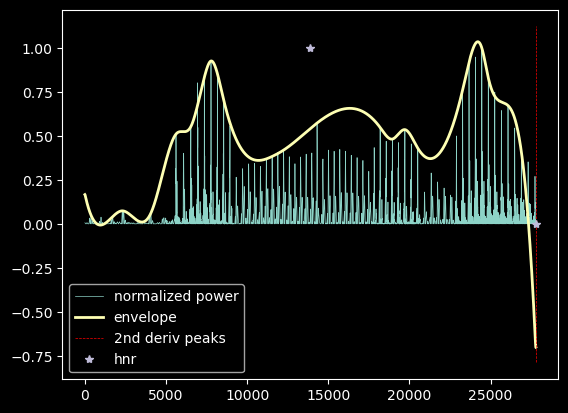

In [109]:
hnr_frames_pow = [get_HNR(f, Fs) for f in frames_pow]
hnr_frames_pow /= max(hnr_frames_pow)
plt.figure()
plt.plot(power, label="normalized power")
plt.plot(tt, env, linewidth=2, label="envelope")
plt.vlines(
    peaks_d2, *plt.ylim(), linestyles="dashed", colors="r", label="2nd deriv peaks"
)
plt.plot((starts + ends) / 2, hnr_frames_pow, "*", label="hnr")
plt.legend()
plt.show()

hnr_sort = np.argsort(-np.array(hnr_frames_pow))
n_vowels = len(vowels_per_segment[k])

frames_vowel = [frames_pow[i] for i in hnr_sort[:n_vowels]]

wavfile.write(
    f"output/vowels{n_vowels}_pow.wav",
    Fs,
    tools.stitch_frames(frames_vowel, padding=Fs / 2),
)